In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'w'
# import seaborn as sns
# from sklearn.linear_model import LinearRegression

In [20]:
import arviz as az
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [85]:
df0 = pd.read_excel('data/data_Statistical_Rethinking.xlsx', sheet_name='Howell1')

In [86]:
df = df0[df0['age'] >= 18]
df.head(2)

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0


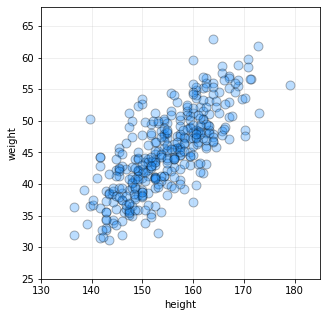

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
xmin, xmax = 130, 185
ymin, ymax = 25, 68
xaxis, yaxis = 'height', 'weight'
ax.scatter(df[xaxis], df[yaxis], s=80, alpha=0.3, 
           fc='dodgerblue', ec='k')
ax.set(xlabel=xaxis, ylabel=yaxis, xlim=[xmin,xmax], ylim=[ymin,ymax])
ax.grid(lw=1, alpha=0.2, zorder=0);

Statistical Rethinking 2022 Lecture 03 - Geocentric Models

$$ W_i \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu_i \sim \alpha + \beta (H_i- \bar{H}) $$

In [35]:
# sample the priors: 0:48:20
n_samples = 10
mu, sigma = 60, 10
alpha = np.random.normal(loc=mu, scale=sigma, size=n_samples)
mu, sigma = 0, 10
beta = np.random.normal(loc=mu, scale=sigma, size=n_samples)

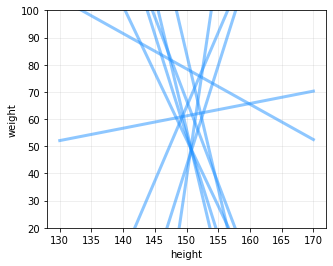

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
x_axis = np.linspace(130, 170)
for a, b in zip(alpha, beta):
    ax.plot(x_axis, a + b*(x_axis-150), c='dodgerblue', lw=3, alpha=0.5)
ax.set(xlabel=xaxis, ylabel=yaxis, ylim=[20, 100])
ax.grid(lw=1, alpha=0.2, zorder=0);

In [143]:
# sample the better priors: 0:52:00
n_samples = 10
mu, sigma = 60, 10
alpha = np.random.normal(loc=mu, scale=sigma, size=n_samples)
mu, sigma = 0, 1
beta = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)

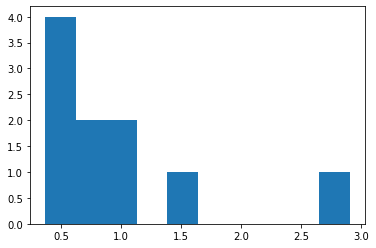

In [145]:
plt.hist(beta);

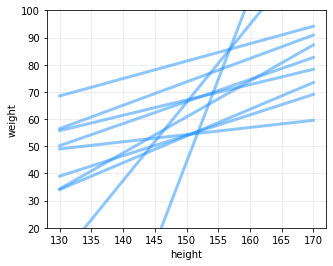

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
x_axis = np.linspace(130, 170)
for a, b in zip(alpha, beta):
    ax.plot(x_axis, a + b*(x_axis-150), c='dodgerblue', lw=3, alpha=0.5)
ax.set(xlabel=xaxis, ylabel=yaxis, ylim=[20, 100])
ax.grid(lw=1, alpha=0.2, zorder=0);

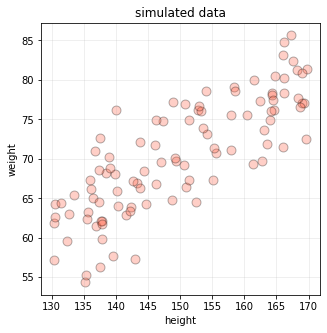

In [147]:
# simulate data from synthetic values for the parameters
alpha, beta, sigma = 70, 0.5, 5
n_samples = 100
x = np.random.uniform(130, 170, size=n_samples)
xbar = x.mean()
mu = alpha + beta * (x-xbar)
y = np.random.normal(loc=mu, scale=sigma, size=n_samples)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
xmin, xmax = 130, 185
ymin, ymax = 25, 68
xaxis, yaxis = 'height', 'weight'
ax.scatter(x, y, s=80, alpha=0.3, 
           fc='tomato', ec='k')
ax.set( title='simulated data', xlabel=xaxis, ylabel=yaxis)#, xlim=[xmin,xmax], ylim=[ymin,ymax])
ax.grid(lw=1, alpha=0.2, zorder=0);

In [148]:
with pm.Model() as model:
    a = pm.Normal("a", mu=60, sd=10)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 10)
    # x, y = df['height'], df['weight']
    # xbar = df['height'].mean()
    mu = a + b * (x - xbar)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=y)
    trace = pm.sample(1000, tune=1000)

C:\Users\jorge\miniconda3\envs\env-pym3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.


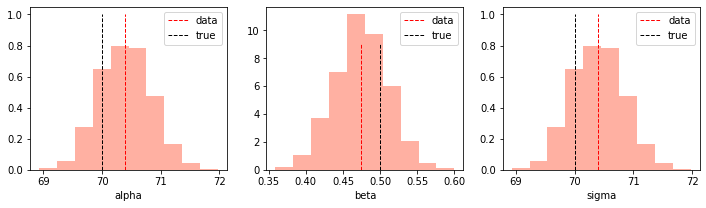

In [150]:
df_pm = pm.trace_to_dataframe(trace).round(3)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
ax = axs[0]
ax.hist(df_pm['a'], density=True, color='tomato', alpha=.5)
ax.plot([df_pm['a'].mean(),df_pm['a'].mean()], [0,1], 'r--', lw=1, label='data')
ax.plot([alpha,alpha], [0,1], 'k--', lw=1, label='true')
ax.set(xlabel='alpha')
ax.legend()

ax = axs[1]
ax.hist(df_pm['b'], density=True, color='tomato', alpha=.5)
ax.plot([df_pm['b'].mean(),df_pm['b'].mean()], [0,9], 'r--', lw=1, label='data')
ax.plot([beta,beta], [0,9], 'k--', lw=1, label='true')
ax.set(xlabel='beta')
ax.legend()

ax = axs[2]
ax.hist(df_pm['a'], density=True, color='tomato', alpha=.5)
ax.plot([df_pm['a'].mean(),df_pm['a'].mean()], [0,1], 'r--', lw=1, label='data')
ax.plot([alpha,alpha], [0,1], 'k--', lw=1, label='true')
ax.set(xlabel='sigma')
ax.legend();

In [123]:
# use actual data (1:10:00)
with pm.Model() as model:
    a = pm.Normal("a", mu=60, sd=10)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 10)
    x, y = df['height'], df['weight']
    xbar = df['height'].mean()
    mu = a + b * (x - xbar)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=y)
    trace = pm.sample(1000, tune=1000)

C:\Users\jorge\miniconda3\envs\env-pym3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31 seconds.


C:\Users\jorge\AppData\Local\Temp\ipykernel_16052\3409867147.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace);
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\jorge\miniconda3\envs\env-pym3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


<Figure size 504x504 with 0 Axes>

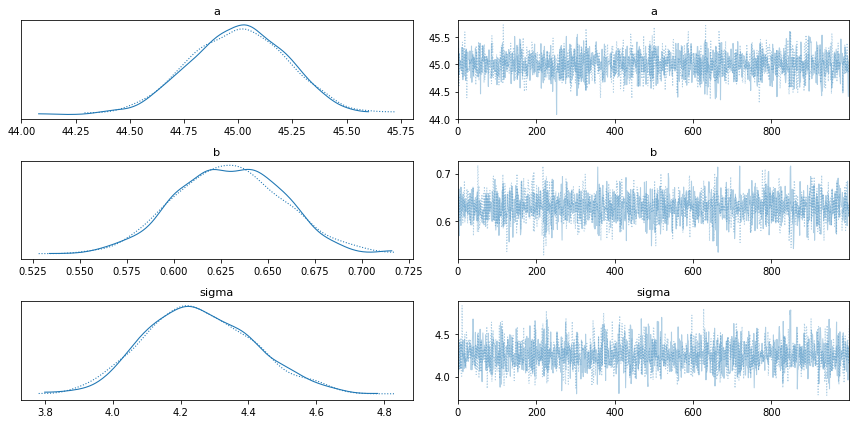

In [124]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace);
plt.tight_layout();

In [125]:
df_pm = pm.trace_to_dataframe(trace).round(3)
# df_pm.cov()

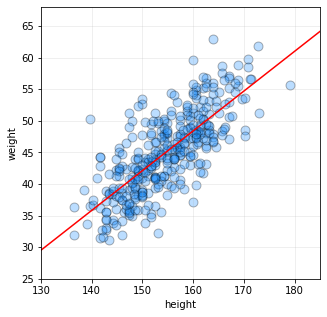

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
xmin, xmax = 130, 185
ymin, ymax = 25, 68
xaxis, yaxis = 'height', 'weight'
ax.scatter(data[xaxis], data[yaxis], s=80, alpha=0.3, 
           fc='dodgerblue', ec='k')
alpha = df_pm['a'].mean()
beta  = df_pm['b'].mean()
x_axis = np.linspace(100, 200)
ax.plot(x_axis, alpha + beta * (x_axis-xbar), 'r-')
ax.set(xlabel=xaxis, ylabel=yaxis, xlim=[xmin,xmax], ylim=[ymin,ymax])
ax.grid(lw=1, alpha=0.2, zorder=0);

In [137]:
height_seq = np.arange(xmin, xmax)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
trace_thinned = trace[::10]
mu_pred = np.zeros((len(height_seq), len(trace_thinned) * trace.nchains))
for i, h in enumerate(height_seq):
    mu_pred[i] = trace_thinned["a"] + trace_thinned["b"] * (h - df['height'].mean())

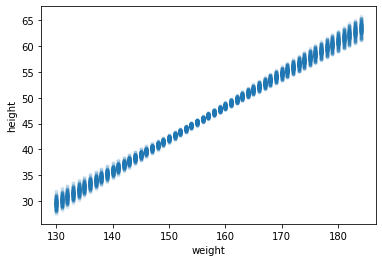

In [139]:
plt.plot(height_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height");

C:\Users\jorge\AppData\Local\Temp\ipykernel_16052\670594516.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi = az.hdi(mu_pred.T)
C:\Users\jorge\miniconda3\envs\env-pym3\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


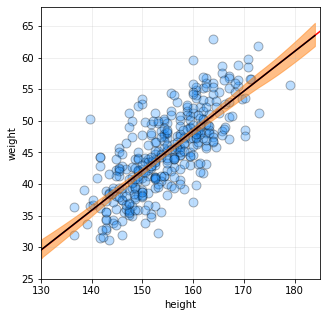

In [141]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
xmin, xmax = 130, 185
ymin, ymax = 25, 68
xaxis, yaxis = 'height', 'weight'
ax.scatter(data[xaxis], data[yaxis], s=80, alpha=0.3, 
           fc='dodgerblue', ec='k')
alpha = df_pm['a'].mean()
beta  = df_pm['b'].mean()
x_axis = np.linspace(100, 200)
ax.plot(x_axis, alpha + beta * (x_axis-xbar), 'r-')

mu_mean = mu_pred.mean(1)
mu_hdi = az.hdi(mu_pred.T)
az.plot_hdi(height_seq, mu_pred.T)
plt.plot(height_seq, mu_mean, "k")

ax.set(xlabel=xaxis, ylabel=yaxis, xlim=[xmin,xmax], ylim=[ymin,ymax])
ax.grid(lw=1, alpha=0.2, zorder=0);